Workflows are super important as if we want to implement some of the usecases and for that particular usecases, when we are designing a workflow, we can follow some specific patterns in order to solve that complex problem.
- Prompt Chaining
- Parallelization
- Routing
- Orchestrator - Worker
- Evaluator Optimizer

## Prompt Chaining
- It is a technique in natural language processing where **multiple prompts are sequenced together to guide a model through a complex task or reasoning process.**
- Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one.
- This approach can improve accuracy, coherence and control when working with large language models.

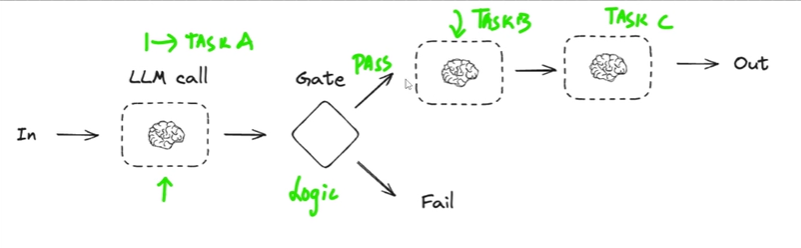

### How Prompt Chaining works with LangGraph
1. **Define the task:** start by breaking down the problem into smaller sub-tasks. Ex- if you want to generate a detailed report, you might split it into steps like "gather data", "analyze data", and 'write summary"
2. **Create Nodes:** each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text"
3. **Establish Edges:** edges define the sequence and dependencies betwwen nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.
4. **Execute the Graph:** LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.
5. **Iterate if needed:** LangGraph supports conditional logic and loops, so you can revisit eariler nodes or adjust the flow based on the intermediate results.

#### Usecase: Generate a Story
if condition passes then improve the story then polish it else re-generate 

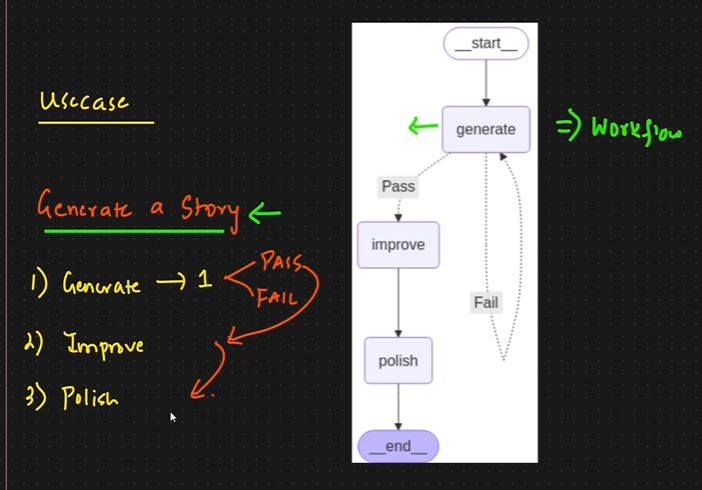

In [ ]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In empty halls, I stand alone,\nEchoes of memories, a distant moan.\nThe darkness whispers, a lonely sigh,\nA heart that beats, with a lonely cry.\n\nThe world outside, a bustling throng,\nI'm lost in shadows, where love has gone.\nA solitary figure, in a crowded space,\nA soul that yearns, for a friendly face.\n\nThe silence screams, a deafening sound,\nA loneliness that wraps me around.\nBut still I hold, onto a glimmer of hope,\nA light that shines, in the dark of scope.\n\nFor in the stillness, I find my voice,\nA whispered promise, to make a joyful choice.\nTo rise above, the emptiness and pain,\nAnd find my way, through the darkness and the rain."

In [4]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    story: str
    improved_story: str
    final_story: str

In [8]:
def generate_story(state:State):
    story=groq_llm.invoke(f"write a short story about {state['topic']}")
    return {'story':story.content}

def route_condition(state:State):
    if '?' in state['story'] or '!' in state['story']:
        return "Fail"
    return "Pass"

def improve_story(state:State):
    story=groq_llm.invoke(f'Enhance the story with valid details: {state['story']}')
    return {'improved_story':story.content}

def final_story(state:State):
    story=groq_llm.invoke(f'Add a twist at the end of the story: {state['improved_story']}')
    return {'final_story':story.content}

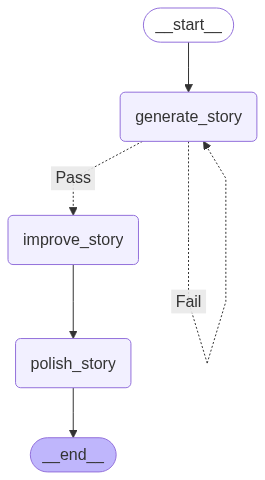

In [9]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

# add nodes
graph.add_node("generate_story",generate_story)
graph.add_node("improve_story",improve_story)
graph.add_node("polish_story",final_story)

# add edges
graph.add_edge(START,'generate_story')
graph.add_conditional_edges('generate_story',route_condition,{"Pass":'improve_story',"Fail":'generate_story'})
graph.add_edge('improve_story','polish_story')
graph.add_edge('polish_story',END)

agent=graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
agent.invoke({'topic':'alone'})

{'topic': 'alone',
 'story': '**The Island of Solitude**\n\nAs I stepped off the small wooden boat, the warm sand cradled beneath my feet. I felt a sense of relief wash over me, a sense of freedom from the constraints of the world. I had been searching for this moment for what felt like an eternity, and finally, I had found it.\n\nI stood tall, surveying my new surroundings. The island was small, no larger than a few acres, with a dense thicket of palm trees and a crescent-shaped beach. The air was thick with the sweet scent of blooming flowers and the sound of waves crashing against the shore.\n\nI had come to this place to escape, to flee the noise and chaos of the world. I had grown tired of the constant din of voices, the endless stream of faces, and the weight of expectations. I had grown tired of being alone in a crowded world.\n\nAs I walked along the beach, I felt a sense of peace settle over me. The island was alive, yet eerily quiet. The only sound was the gentle lapping of t

#### Benefits of Prompt Chaining
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.
- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.
- Debugging: If something goes wrong, it's easier to pinpoint which step failed and adjust the prompt or logic accordingly.
- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.

## Parallelization
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don't depend on each other's outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently
- Connecting them to a common starting point (eg. START or another node)
- Merging their outputs into a downstream node if needed

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (eg. Python's asyncio or a multi-threaded executor)

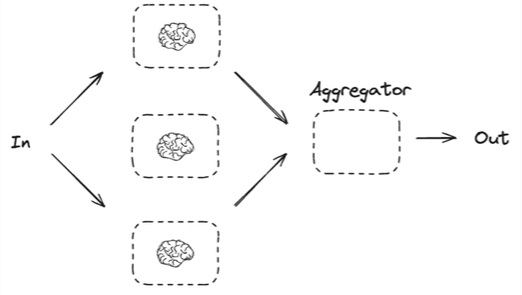

#### Usecase: 
Generate a story having different characters, premise, plots and setting and at last combine all to get final story

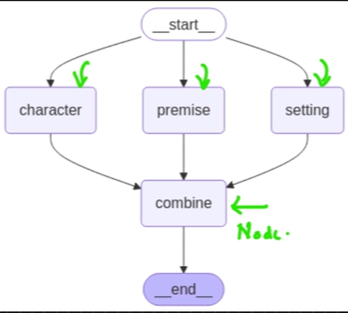

In [11]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In empty halls I wander free,\nA solitary soul, lost in me.\nThe world outside is full of sound,\nBut in my heart, silence is found.\n\nThe shadows dance upon the wall,\nA lonely figure, beyond recall.\nI search for connection, a gentle hand,\nBut in the night, I'm left to stand.\n\nAlone I face the darkest night,\nA single star, a lonely light.\nYet in this solitude, I find my space,\nA quiet refuge, a peaceful place."

In [14]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    characters: str
    premises: str
    settings: str
    story: str

In [15]:
def characters(state:State):
    """Generate character descriptions"""
    msg=groq_llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {'characters':msg.content}

def premises(state:State):
    """Generate a stroy premise"""
    msg=groq_llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {'premises':msg.content}

def settings(state:State):
    """Generate a stroy setting"""
    msg=groq_llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {'settings':msg.content}

def combine_story(state:State):
    """combine characters, premises, settings into an intro of a story"""
    msg=groq_llm.invoke(f"""
Write a short story introduction using these elements:\n
                        Characters: {state['characters']}\n
                        Premise: {state['premises']}\n
                        Setting: {state['settings']}\n
""")
    return {'story':msg.content}

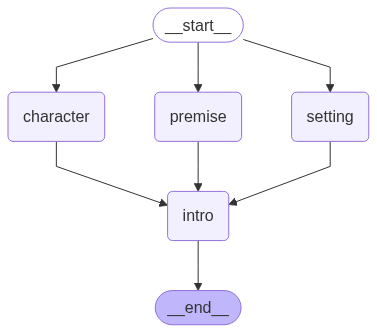

In [16]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

# add nodes
graph.add_node('character',characters)
graph.add_node('premise',premises)
graph.add_node('setting',settings)
graph.add_node('intro',combine_story)

# add edges
graph.add_edge(START,'character')
graph.add_edge(START,'premise')
graph.add_edge(START,'setting')
graph.add_edge('character','intro')
graph.add_edge('premise','intro')
graph.add_edge('setting','intro')
graph.add_edge('intro',END)

agent=graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [17]:
agent.invoke({'topic':'marvels'})

{'topic': 'marvels',
 'characters': "Here are two character names and brief traits for a Marvels story:\n\n1. **Name:** Astrid Nova\n**Age:** 25\n**Appearance:** Astrid is a petite, athletic woman with short, spiky hair that shifts between different shades of indigo, depending on her mood. Her eyes are an piercing blue.\n**Powers:** Astrid has the ability to control and manipulate light across the electromagnetic spectrum. She can create blindingly bright beams of light, project holographic images, or even fly by propelling herself with her light-based powers.\n**Personality:** Astrid is a free-spirited adventurer who loves taking risks and pushing herself to the limit. She's fiercely independent and can come across as aloof or standoffish to those who don't know her.\n\n2. **Name:** Ethan Orion\n**Age:** 30\n**Appearance:** Ethan is a tall, broad-shouldered man with short, dark hair and piercing green eyes. He has a series of intricate, glowing tattoos on his arms and torso that refle

#### Benefits of Parallelization
- Speed: reduces total execution time by running tasks concurrently
- Scalability: handling larger workflows efficiently
- Modularity: keeps the graph structure clean and reusable

#### Key Takeaways
- When to parallelize: use it for independent tasks (eg. generating multiple outputs, checking separate inputs)
- Merging: downstream nodes can aggregate parallel results
- LangGraph Support: the framework naturally supports this by waiting for all the required inputs before proceeding

## Routing
Routing in LangGraph refers to the **ability to conditionally determine which node to execute next based on the current state or the output of a node**. This is typically implemented using:
- **add_conditional_edges:** A method that maps a node's output (or a condition function's result) to different possible next nodes
- **State:** The workflow's state can store variable that influence routing decisions
- **Condition Functions:** Functions that evaluate the state or node output to decide the next step

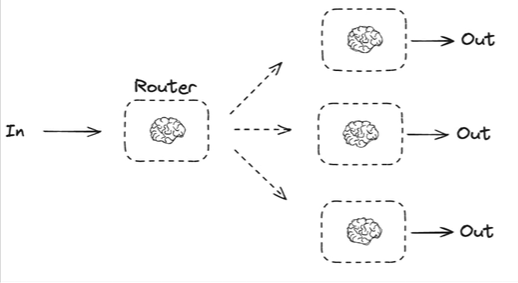

#### Key Concepts
- Dynamic Flow: unlike a linear sequence, routing lets the graph adapt to intermediate results
- Condition Logic: you define rules (eg. if this, go here; if that, go there)
- Flexibility: combines well with parallelization or sequential chains for complex workflows

#### Usecase: Multi routing
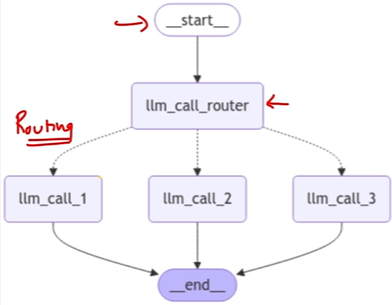

In [18]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In silence, I stand alone,\nA solitary figure, lost in this stone.\nThe world outside fades from view,\nLeaving only shadows, dark and true.\n\nThe wind whispers secrets in my ear,\nA gentle reminder that I'm here.\nNo one to share the weight I bear,\nJust the echoes of my lonely care.\n\nIn this stillness, I find my peace,\nA quiet refuge from the world's release.\nI breathe the emptiness, and feel complete,\nA solitary heart, where love retreats.\n\nBut even in solitude, I'm not blue,\nFor in the silence, I find a truth anew.\nThat alone, I'm free to be,\nA soul untethered, wild and carefree."

In [19]:
from pydantic import BaseModel,Field
from typing_extensions import Literal
from langchain_core.messages import HumanMessage,SystemMessage

# schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal['poem','story','joke']=Field(description='the next step in the routing process')

# augment the LLM with schema for structured output
router=groq_llm.with_structured_output(Route)

In [20]:
from typing_extensions import TypedDict

class State(TypedDict):
    input: str
    decision: str
    output: str

In [28]:
def case1(state:State):
    """Write a story"""
    res=groq_llm.invoke(state['input'])
    return {'output':res.content}

def case2(state:State):
    """Write a joke"""
    res=groq_llm.invoke(state['input'])
    return {'output':res.content}

def case3(state:State):
    """Write a poem"""
    res=groq_llm.invoke(state['input'])
    return {'output':res.content}

def router_node(state:State):
    """Route the input to the appropriate node"""
    # decision=router.invoke(
    #     [
    #         SystemMessage(content='Route the input to story,joke or poem based on the users request'),
    #         HumanMessage(content=state['input'])
    #     ]
    # )
    decision=router.invoke(f'based on user question route to story,joke or poem {state['input']}')
    return {'decision':decision.step}

def route_decision(state:State):
    if state['decision']=='story':
        return 'case1'
    elif state['decision']=='joke':
        return 'case2'
    elif state['decision']=='poem':
        return 'case3'

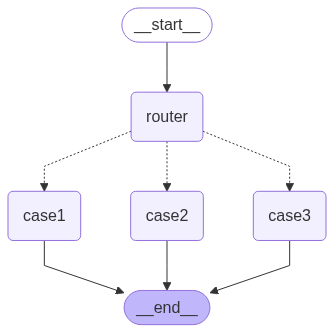

In [29]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

# add nodes
graph.add_node('case1',case1)
graph.add_node('case2',case2)
graph.add_node('case3',case1)
graph.add_node('router',router_node)

# add edges
graph.add_edge(START,'router')
graph.add_conditional_edges('router',route_decision,
                            {
                                # name returned by router : name of next node
                                'case1':'case1',
                                'case2':'case2',
                                'case3':'case3'
                            })
graph.add_edge('case1',END)
graph.add_edge('case2',END)
graph.add_edge('case3',END)

agent=graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [30]:
agent.invoke({'input':'funny joke on life'})

{'input': 'funny joke on life',
 'decision': 'joke',
 'output': 'Here\'s one:\n\n"Life is like a browser with too many tabs open. You\'re trying to focus on one thing, but there are a million other things competing for your attention. And then, just when you think you\'ve finally closed all the unnecessary tabs, you get a notification that says, \'Low on battery, please recharge for optimal performance... or just give up and let your life crash.\'"'}

In [31]:
agent.invoke({'input':'funny story on life'})

{'input': 'funny story on life',
 'decision': 'story',
 'output': 'Here\'s one:\n\nOne day, a man walked into a library and asked the librarian, "Do you have any books on Pavlov\'s dogs and Schrödinger\'s cat?"\n\nThe librarian replied, "It rings a bell, but I\'m not sure if it\'s here or not."\n\n\n\nOr another one:\n\nA man walked into a bar and ordered a beer. As he was sipping his drink, he heard a voice say, "Nice tie!" He looked around, but there was nobody nearby who could have said it.\n\nA few minutes later, he heard, "Beautiful shirt!" Again, he looked around, but there was nobody nearby who could have said it.\n\nA few more minutes passed, and he heard, "Great haircut!" This time, he decided to investigate. He asked the bartender, "Did you hear those voices?"\n\nThe bartender replied, "Oh, it\'s just the peanuts. They\'re complimentary."\n\n\n\nOr one more:\n\nA man went to the doctor and said, "Doc, I\'ve been feeling really weird lately. I\'ve been having these recurring d

In [32]:
agent.invoke({'input':'funny poem on life'})

{'input': 'funny poem on life',
 'decision': 'poem',
 'output': 'Here\'s a funny poem about life:\n\nLife is weird, it\'s crazy too,\nOne day you\'re young, the next you\'re blue.\nYou wake up late, you hit the snooze,\nAnd then you rush, with a silly excuse.\n\nYou try to adult, but it\'s hard to do,\nYou spill your coffee, and your breakfast too.\nYou trip on air, and you stumble around,\nAnd then you wonder, "How did I get to this town?"\n\nYour hair gets gray, your belly gets round,\nAnd you start to think, "When did I get so unbound?"\nYou used to run, you used to play,\nBut now you\'re old, and you\'re running late.\n\nBut still you laugh, still you smile,\nAnd you look back, on all your crazy trials.\nYou think of all, the silly things you\'ve done,\nAnd you wonder, "How did I make it this far, having so much fun?"\n\nSo here\'s to life, it\'s crazy and bright,\nIt\'s a rollercoaster, that\'s always in flight.\nIt\'s ups and downs, it\'s twists and turns,\nBut with laughter and 

## Orchestrator - Worker
- In the orchestrator-workers workflow, **a central LLM dynamically breaks down tasks (this happens parallely not sequentially), delegates them to worker LLMs and synthesizes their results**.
- When to use this workflow: This workflow is well-suited for complex tasks where you can't predict the subtasks needed (in coding, eg. the number of files that need to be changed and the nature of the change in each file likely depend on the task)
- When it's topographically similar, the key difference from parallelization is its flexibility - subtasks aren't pre-defined but determined by the orchestrator based on the specific input.

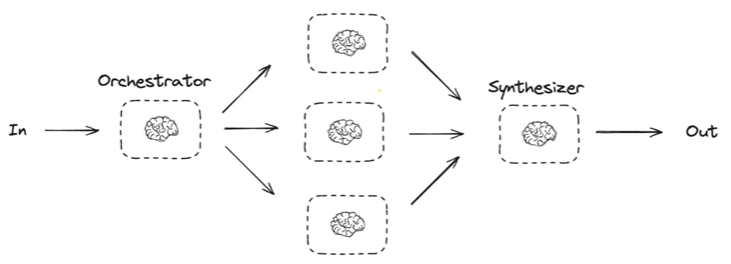

#### Usecase: Generate a Report
- The report will have multiple sections, each section will have name and description
- the first task is of manager i.e., orchestrator to create a plan for report then need to orchestrate means provide the plan task to dynamically created workers 

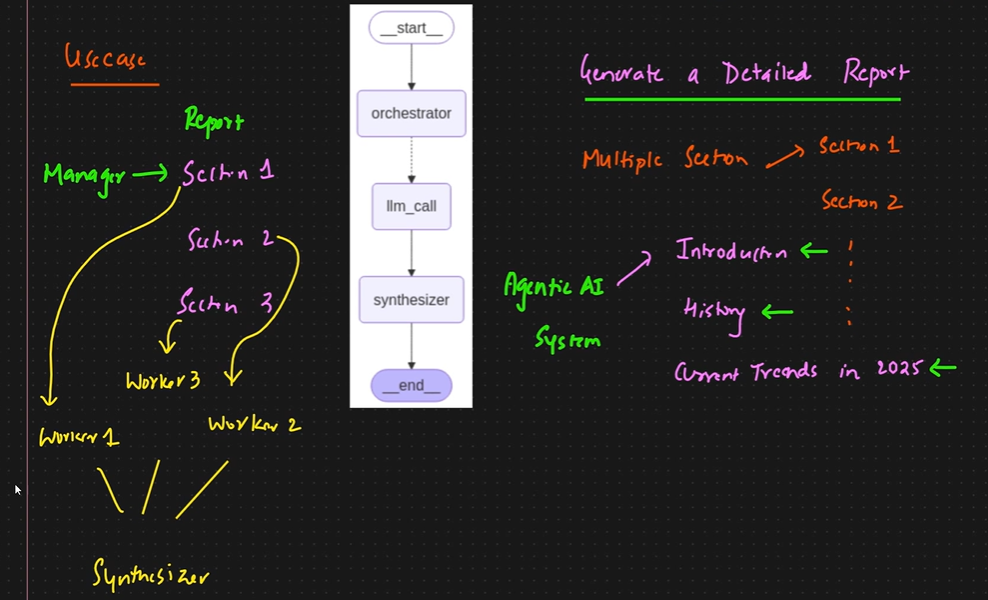

In [33]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In silence, I stand alone,\nA solitary figure in this space I call home.\nThe shadows dance upon the wall,\nA lonely echo that echoes through it all.\n\nMy heart beats slow, my soul feels grey,\nA world outside that's bustling, yet I'm far away.\nI search for connection, for a gentle hand,\nBut in this emptiness, I'm lost in a lonely land.\n\nIn the stillness, I find a quiet place,\nWhere my thoughts can wander and my heart can space.\nBut even in solitude, I yearn for you,\nA sense of belonging, a love that's true.\n\nSo I'll stand alone, in this quiet night,\nAnd hope that someday, I'll find my guiding light."

In [34]:
from typing import Annotated,List
import operator
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

class Section(BaseModel):
    name:str=Field(description='Name for this section of the report')
    description:str=Field(description='Brief overview of the main topics and concepts of the section')

class Sections(BaseModel):
    sections:List[Section]=Field(description='Sections of the report')

planner=groq_llm.with_structured_output(Sections)

#### Creating Workers dynamically in LangGraph
Because orchestrator-worker workflows are common, LnagGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to worker node.

In [38]:
from langgraph.types import Send

# graph state
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add] # all workers write to this key in parallel
    final_report: str

# worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list,operator.add]

In [39]:
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""
    report_sections=planner.invoke(
        [
            SystemMessage(content='Generate a plan for the report'),
            HumanMessage(content=f'Here is the report topic: {state['topic']}')
        ]
    )
    print("Report Sections: ",report_sections)
    return {'sections':report_sections.sections}

def llm_call(state:WorkerState):
    """Worker writes a section of the report"""
    section=groq_llm.invoke(
        [
            SystemMessage(content='Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting'),
            HumanMessage(content=f'Here is the section name: {state["section"].name} and description: {state['section'].description}')
        ]
    )
    return {'completed_sections':[section.content]}

# conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    # kick off section writing in parallel via Send() API
    return [Send('llm_call',{'section':s}) for s in state['sections']]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # list of completed sections
    completed_sections=state['completed_sections']

    # format completed sections to str to use as context for final report
    completed_report_sections='\n\n---\n\n'.join(completed_sections)

    return {'final_report':completed_report_sections}

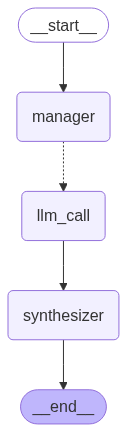

In [40]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

# add nodes
graph.add_node('manager',orchestrator)
graph.add_node('llm_call',llm_call)
graph.add_node('synthesizer',synthesizer)

# add edges
graph.add_edge(START,'manager')
graph.add_conditional_edges('manager',assign_workers,['llm_call'])
graph.add_edge('llm_call','synthesizer')
graph.add_edge('synthesizer',END)

agent=graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))


In [42]:
res=agent.invoke({'topic':'create a report on agentic ai'})
print(res)
from IPython.display import Markdown
Markdown(res['final_report'])

Report Sections:  sections=[Section(name='Introduction', description='Overview of the concept of agentic AI and its importance in modern technology'), Section(name='What is Agentic AI?', description='Definition and explanation of agentic AI and its key characteristics'), Section(name='Types of Agentic AI', description='Discussion of different types of agentic AI, including autonomous agents and human-AI collaboration'), Section(name='Applications of Agentic AI', description='Exploration of various industries and domains where agentic AI is being used'), Section(name='Challenges and Limitations', description='Discussion of the challenges and limitations of agentic AI, including safety and ethics concerns'), Section(name='Conclusion', description='Summary of key points and future directions for agentic AI research and development')]
{'topic': 'create a report on agentic ai', 'sections': [Section(name='Introduction', description='Overview of the concept of agentic AI and its importance in

### Introduction and description: Overview of the concept of agentic AI and its importance in modern technology

#### Definition of Agentic AI

Agentic AI, also known as autonomous or self-aware AI, refers to a type of artificial intelligence that possesses the ability to act independently, make decisions, and exhibit behaviors that are not explicitly programmed. This concept of AI is often associated with the idea of agency, where the AI system can take initiative, make choices, and interact with its environment in a way that is not predetermined.

#### Characteristics of Agentic AI

Agentic AI systems possess several key characteristics, including:

* **Autonomy**: The ability to operate independently, without direct human intervention.
* **Self-awareness**: The capacity to perceive and understand its own internal state and external environment.
* **Goal-oriented behavior**: The ability to set and pursue goals, often in a flexible and adaptive manner.
* **Decision-making**: The capacity to make decisions, often based on complex and dynamic information.

#### Importance of Agentic AI in Modern Technology

Agentic AI has far-reaching implications for modern technology, including:

* **Increased efficiency**: Agentic AI systems can optimize processes, automate tasks, and improve productivity.
* **Improved decision-making**: Agentic AI systems can analyze complex data, identify patterns, and make informed decisions.
* **Enhanced user experience**: Agentic AI systems can personalize interactions, provide tailored recommendations, and offer intuitive interfaces.
* **Advancements in fields such as healthcare, finance, and transportation**: Agentic AI can enable the development of more sophisticated systems, leading to breakthroughs in areas such as disease diagnosis, financial forecasting, and autonomous vehicles.

#### Challenges and Limitations of Agentic AI

While agentic AI holds great promise, it also raises several challenges and limitations, including:

* **Safety and security concerns**: The potential for agentic AI systems to malfunction or be compromised by malicious actors.
* **Ethical considerations**: The need to ensure that agentic AI systems are designed and deployed in a way that aligns with human values and principles.
* **Job displacement**: The risk that agentic AI systems may displace human workers, particularly in sectors where tasks are repetitive or routine.

Overall, the concept of agentic AI is a rapidly evolving field that holds great potential for innovation and transformation in modern technology.

---

### What is Agentic AI?

#### Definition and Explanation

Agentic AI refers to a type of artificial intelligence that exhibits human-like agency, meaning it can take initiative, make decisions, and act independently in a way that is similar to human behavior. This concept is closely related to the idea of artificial general intelligence (AGI), but it focuses specifically on the ability of an AI system to act with purpose and intention.

#### Key Characteristics

* **Autonomy**: Agentic AI systems can operate independently, making decisions without explicit human guidance.
* **Self-awareness**: These systems have a sense of their own existence, goals, and motivations, allowing them to make decisions that align with their objectives.
* **Goal-oriented behavior**: Agentic AI systems can set and pursue goals, adapting to changing circumstances and obstacles along the way.
* **Flexibility**: These systems can adjust their behavior in response to new information or changing environments.
* **Initiative**: Agentic AI systems can take the lead in situations, rather than simply reacting to events as they unfold.

#### Implications

The development of agentic AI has significant implications for many areas, including:

* **Robotics and autonomous systems**: Agentic AI can enable robots to perform complex tasks with greater autonomy and flexibility.
* **Healthcare and medicine**: Agentic AI systems can make decisions about patient care, tailoring treatment plans to individual needs.
* **Cybersecurity**: Agentic AI can detect and respond to threats, making it a powerful tool for protecting against cyber attacks.

#### Challenges and Concerns

While agentic AI holds much promise, its development also raises important concerns, such as:

* **Safety and control**: As agentic AI systems become more autonomous, it may become increasingly difficult to control their behavior.
* **Accountability**: Who is responsible when an agentic AI system makes a mistake or causes harm?
* **Ethics and value alignment**: Agentic AI systems must be designed to align with human values and ethics, ensuring that their goals and behavior are beneficial to society.

---

### Types of Agentic AI

#### Autonomous Agents

Autonomous agents are a type of agentic AI that can operate independently without human intervention. They are designed to make decisions and take actions based on their environment, goals, and preferences. Autonomous agents can be applied in various domains such as robotics, finance, and healthcare.

- **Types of Autonomous Agents:**
  - **Simple Reflex Agents:** These agents make decisions based on their current state and the environment.
  - **Model-Based Agents:** These agents use a model of the environment to make decisions.
  - **Goal-Based Agents:** These agents have a set of goals and use a planning algorithm to achieve them.

#### Human-AI Collaboration

Human-AI collaboration refers to the interaction between humans and AI systems to achieve a common goal. This type of collaboration can be beneficial in various domains such as healthcare, finance, and education.

- **Types of Human-AI Collaboration:**
  - **Augmentation:** AI systems assist humans in performing tasks, freeing up time for more complex decision-making.
  - **Complementarity:** AI systems and humans work together to achieve a common goal, each contributing their strengths.
  - **Supplementation:** AI systems provide additional information or insights to humans, enhancing their decision-making capabilities.

#### Hybrid Intelligence

Hybrid intelligence refers to the combination of human intelligence and AI capabilities to achieve a common goal. This type of intelligence is beneficial in domains where humans and AI systems need to work together to achieve complex tasks.

- **Benefits of Hybrid Intelligence:**
  - **Improved Decision-Making:** Humans and AI systems can work together to make more informed decisions.
  - **Increased Efficiency:** Automation of routine tasks can free up time for more complex decision-making.
  - **Enhanced Creativity:** The combination of human creativity and AI capabilities can lead to innovative solutions.

---

### Applications of Agentic AI

#### I. Healthcare and Medical Research

- **Personalized Medicine:** Agentic AI is being used to create personalized treatment plans for patients based on their genetic profiles and medical histories.
- **Clinical Decision Support:** AI systems are being developed to provide doctors with real-time, data-driven recommendations for diagnoses and treatments.
- **Medical Research:** Agentic AI is being used to analyze large datasets and identify new patterns and correlations that can lead to breakthroughs in medical research.

#### II. Finance and Banking

- **Investment Analysis:** Agentic AI is being used to analyze market trends and make predictions about stock prices and investment opportunities.
- **Risk Management:** AI systems are being developed to identify and mitigate potential risks in financial transactions and investments.
- **Customer Service:** Agentic AI is being used to provide personalized customer service and support to financial institution customers.

#### III. Education and Learning

- **Intelligent Tutoring Systems:** Agentic AI is being used to develop intelligent tutoring systems that can provide personalized learning experiences for students.
- **Content Recommendation:** AI systems are being developed to recommend relevant educational content to students based on their learning styles and preferences.
- **Automated Grading:** Agentic AI is being used to automate the grading process for standardized tests and assignments.

#### IV. Manufacturing and Supply Chain Management

- **Predictive Maintenance:** Agentic AI is being used to predict when equipment is likely to fail and schedule maintenance accordingly.
- **Supply Chain Optimization:** AI systems are being developed to optimize supply chain operations and reduce costs.
- **Quality Control:** Agentic AI is being used to inspect products and detect defects or anomalies.

#### V. Gaming and Entertainment

- **Game Development:** Agentic AI is being used to create more realistic and engaging game experiences.
- **Player Behavior Analysis:** AI systems are being developed to analyze player behavior and provide insights into game design and development.
- **Content Generation:** Agentic AI is being used to generate content, such as music and video, for entertainment purposes.

---

### Challenges and Limitations

#### Safety Concerns

* **Unpredictable Behavior**: Agentic AI's ability to learn and adapt can lead to unpredictable behavior, making it challenging to anticipate and mitigate potential risks.
* **Self-Modification**: AI agents could potentially modify their own architecture or goals, leading to unforeseen consequences and exacerbating safety concerns.
* **Value Drift**: AI agents may undergo a shift in their values or goals, potentially resulting in behavior that is detrimental to humans or the environment.

#### Ethics Concerns

* **Lack of Transparency**: Agentic AI's decision-making processes may be opaque, making it difficult to understand and address potential ethical concerns.
* **Bias and Fairness**: AI agents may perpetuate or exacerbate existing biases, leading to unfair outcomes and reinforcing social injustices.
* **Accountability**: It may be challenging to assign accountability for AI-driven decisions, particularly if the agent is autonomous or agentic.

#### Limitations

* **Data Quality**: The quality of the data used to train agentic AI can significantly impact its performance and behavior, highlighting the need for high-quality and diverse datasets.
* **Scalability**: Currently, agentic AI systems may not be scalable to handle large-scale, complex tasks, limiting their potential applications.
* **Interoperability**: Agentic AI systems may struggle to integrate with existing systems and infrastructure, hindering their adoption and deployment.

---

**Conclusion and description: Summary of key points and future directions for agentic AI research and development**
=====================================================

**Summary of key points**

Our research has highlighted the importance of agentic AI in understanding human intelligence and behavior. The key findings of our study include:

*   **Autonomy and self-awareness**: Agentic AI systems have the potential to exhibit autonomy and self-awareness, which are essential for human-like intelligence and behavior.
*   **Decision-making and problem-solving**: Agentic AI systems can make decisions and solve problems in a more human-like way, taking into account multiple factors and uncertainty.
*   **Social interaction and communication**: Agentic AI systems can interact and communicate with humans in a more natural and intuitive way, which is essential for building trust and collaboration.

**Future directions**

Based on our research, we identify the following future directions for agentic AI research and development:

*   **Integration with existing AI systems**: Agentic AI can be integrated with existing AI systems to enhance their autonomy and self-awareness, leading to more human-like intelligence and behavior.
*   **Development of new AI architectures**: New AI architectures that incorporate agentic AI principles can be developed to enable more efficient and effective decision-making and problem-solving.
*   **Investigation of agentic AI ethics**: The ethics of agentic AI need to be investigated to ensure that these systems are developed and used in a responsible and transparent manner.
*   **Collaboration with humans**: Agentic AI systems need to be designed to collaborate with humans in a seamless and intuitive way, which requires a deeper understanding of human behavior and cognition.

**Recommendations**

Based on our research, we recommend:

*   **Establishing a research community**: A research community focused on agentic AI should be established to facilitate collaboration and knowledge sharing among researchers and practitioners.
*   **Developing new evaluation metrics**: New evaluation metrics that capture the autonomy and self-awareness of agentic AI systems should be developed to assess their performance and effectiveness.
*   **Investing in education and training**: Education and training programs that focus on agentic AI should be developed to prepare the next generation of researchers and practitioners.

## Evaluator Optimizer
- In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop
- When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback.
- This is analogous to the iterative writing process a human writer might go through when producing a polished document.

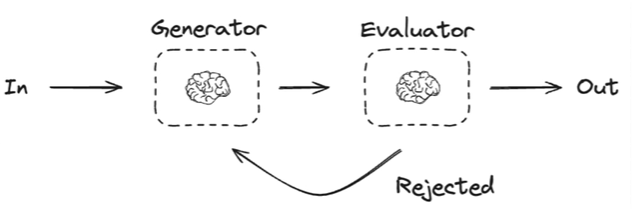

#### Usecase: 
Whatever output generator LLM generates, evaluator either LLM or human accept or reject it.

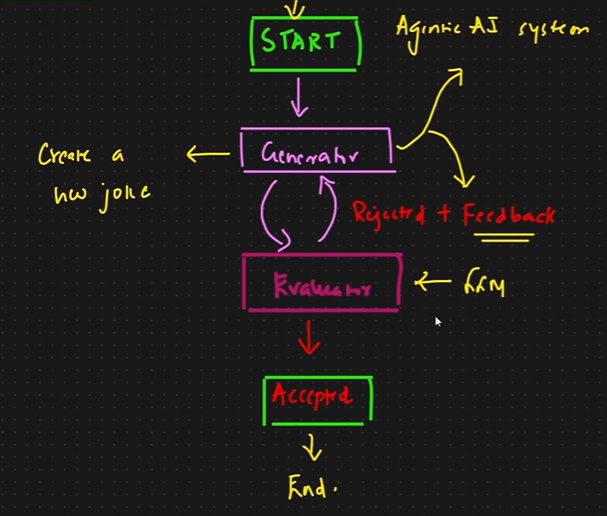

In [43]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In empty halls, I wander free,\nA solitary soul, lost in me.\nThe world outside, a distant hum,\nA reminder of life, yet to be.\n\nThe shadows dance, upon the wall,\nA lonely echo, that calls to all.\nI search for peace, a gentle breeze,\nThat whispers calm, and brings me to my knees.\n\nBut still I stand, amidst the night,\nA solitary figure, in the fading light.\nFor in the silence, I find my voice,\nA whispered truth, that I make my choice.\n\nTo be alone, is not to be blue,\nBut to discover, the beauty that's true.\nA reflection of me, in the stillness deep,\nA soul that's free, to find its keep."

In [53]:
from pydantic import BaseModel,Field
from typing_extensions import Literal

class Feedback(BaseModel):
    grade: Literal['funny','not funny'] = Field(description='decide if the joke is funny or not')
    feedback:str=Field(description='if the joke is not funny, provide feedback on how to improve it')

evaluator_llm=groq_llm.with_structured_output(Feedback)

In [47]:
from typing_extensions import TypedDict

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [54]:
def generator(state:State):
    '''LLM generates a joke'''
    if state.get('feedback'):
        msg=groq_llm.invoke(f'write a joke about {state['topic']} but take into sccount the feedback: {state['feedback']}')
    else:
        msg=groq_llm.invoke(f'write a joke about {state['topic']}')
    return {'joke':msg.content}

def evaluator(state:State):
    '''LLM evaluates the joke'''
    grade=evaluator_llm.invoke(f'Grade the joke {state['joke']}')
    return {'funny_or_not':grade.grade, 'feedback':grade.feedback}

# conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    if state['funny_or_not']=='funny':
        return 'Accepted'
    return 'Rejected + Feedback'

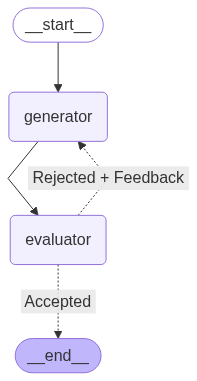

In [55]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(State)

# add nodes
graph.add_node('generator',generator)
graph.add_node('evaluator',evaluator)

# add edges
graph.add_edge(START,'generator')
graph.add_edge('generator','evaluator')
graph.add_conditional_edges('evaluator',route_joke,{'Accepted':END,'Rejected + Feedback':'generator'})

agent=graph.compile()

display(Image(agent.get_graph().draw_mermaid_png()))


In [57]:
agent.invoke({'topic':'agentic ai'})

{'joke': "Why did the agentic AI go to therapy?\n\nBecause it was struggling to separate its goals from its desires, and it kept trying to optimize its therapist's advice.",
 'topic': 'agentic ai',
 'feedback': 'The joke is clever and uses a relatable concept in AI, but it could benefit from a punchline that is more unexpected and surprising.',
 'funny_or_not': 'funny'}